In [132]:
import pandas as pd
import pulp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [133]:
# COAST, NCENT, NORTH, SCENT, SOUTH, WEST, EAST, FWEST
REGION = 'FWEST'
RATING = 500
CAPACITY = 700
ERROR = 0.03

In [134]:
df = pd.read_csv('data/' + REGION + '.csv', parse_dates=['dates'])
df['prediction'] = df['load'].apply(lambda x: x + np.random.normal(0, ERROR*x))
df = df.drop('tempc', axis=1)
df.head()

,load,dates,prediction
0,1094.045496,2002-01-01 00:00:00,1043.140480
1,1083.517981,2002-01-01 01:00:00,1055.631296
2,1085.038740,2002-01-01 02:00:00,1084.899738
3,1093.381853,2002-01-01 03:00:00,1100.781205
4,1106.651296,2002-01-01 04:00:00,1101.772636


In [135]:
MAX_LOAD = df.groupby(df.dates.dt.date)['load'].max().sum()

In [136]:
def heat(l, alpha, time_steps):
    return_l = []
    
    assert time_steps != 0
    
    for t in range(time_steps):
        if len(return_l) != 0:
            l = return_l
            return_l = []
        for i, x in enumerate(l):
            if i == 0:
                diff = (0 - l[i]) - (l[i] - l[i+1])
                return_l.append(l[i] + alpha*diff)
            elif i == len(l) - 1:
                diff = (l[i-1] - l[i]) - (l[i] - 0)
                return_l.append(l[i] + alpha*diff)
            else:
                diff = (l[i-1] - l[i]) - (l[i] - l[i+1])
                return_l.append(l[i] + alpha*diff)

    sum_r = sum(return_l)
    sum_l = sum(l)
    if sum_l != sum_r:
        p = []
        prop = sum_l / sum_r
        return [round(prop*x, 4) for x in return_l]
    else:
        return return_l

def heat_all(l, alpha, time_steps):
    return [heat(day, alpha, time_steps) for day in l]

In [137]:
m = df['load'].tolist()
load_24 = [m[i: i+24] for i in range(0, len(m), 24)]

m = df['prediction'].tolist()
pred_24 = [m[i: i+24] for i in range(0, len(m), 24)]

In [138]:
def optimal_daily(day_load, RATING, CAPACITY):
    ps = max(day_load)
    new_load = list(day_load)
    broken = True
    while broken:
        ps -= 1
        new_load = [ps if l > ps else l for l in new_load]
        diff = [p - l for p, l in zip(day_load, new_load)]
        broken = sum(diff) <= CAPACITY and all([d <= RATING for d in diff])    
    return new_load

n_load_24 = []
for day in load_24:
    n_load_24.append(optimal_daily(day, RATING, CAPACITY))

MAX_LOAD_OPTIMAL = sum([max(d) for d in n_load_24])

In [139]:
def pulp24hrBattery(day_load, RATING, CAPACITY):
    model = pulp.LpProblem("Daily demand charge minimization problem", pulp.LpMinimize)
    power = pulp.LpVariable.dicts("ChargingPower", range(24))

    for i in range(24):
        power[i].lowBound = 0
        power[i].upBound = RATING
    pDemand = pulp.LpVariable("Peak Demand", lowBound=0)

    model += pDemand

    for i in range(24):
        model += pDemand >= day_load[i] - power[i]    
    model += pulp.lpSum(power) <= CAPACITY
    
    model.solve()
    return [power[i].varValue for i in range(24)]

# standard dispatches
dispatch_24 = [pulp24hrBattery(pred, RATING, CAPACITY) for pred in pred_24]

In [140]:
def apply_dispatch(dispatch_24, load_24):
    return sum([max([l - d for l, d in zip(day_load, day_dispatch)]) for day_load, day_dispatch in zip(load_24, dispatch_24)])

In [141]:
r = {}
for alpha in range(0, 51, 5):
    alpha = float(alpha) / 100
    r[alpha] = {}
    for time_step in range(1, 6):
        r[alpha][time_step] = round((MAX_LOAD - apply_dispatch(heat_all(dispatch_24, alpha, time_step), load_24)) / (MAX_LOAD - MAX_LOAD_OPTIMAL) * 100, 2)
    print(alpha, end=' ')

0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 

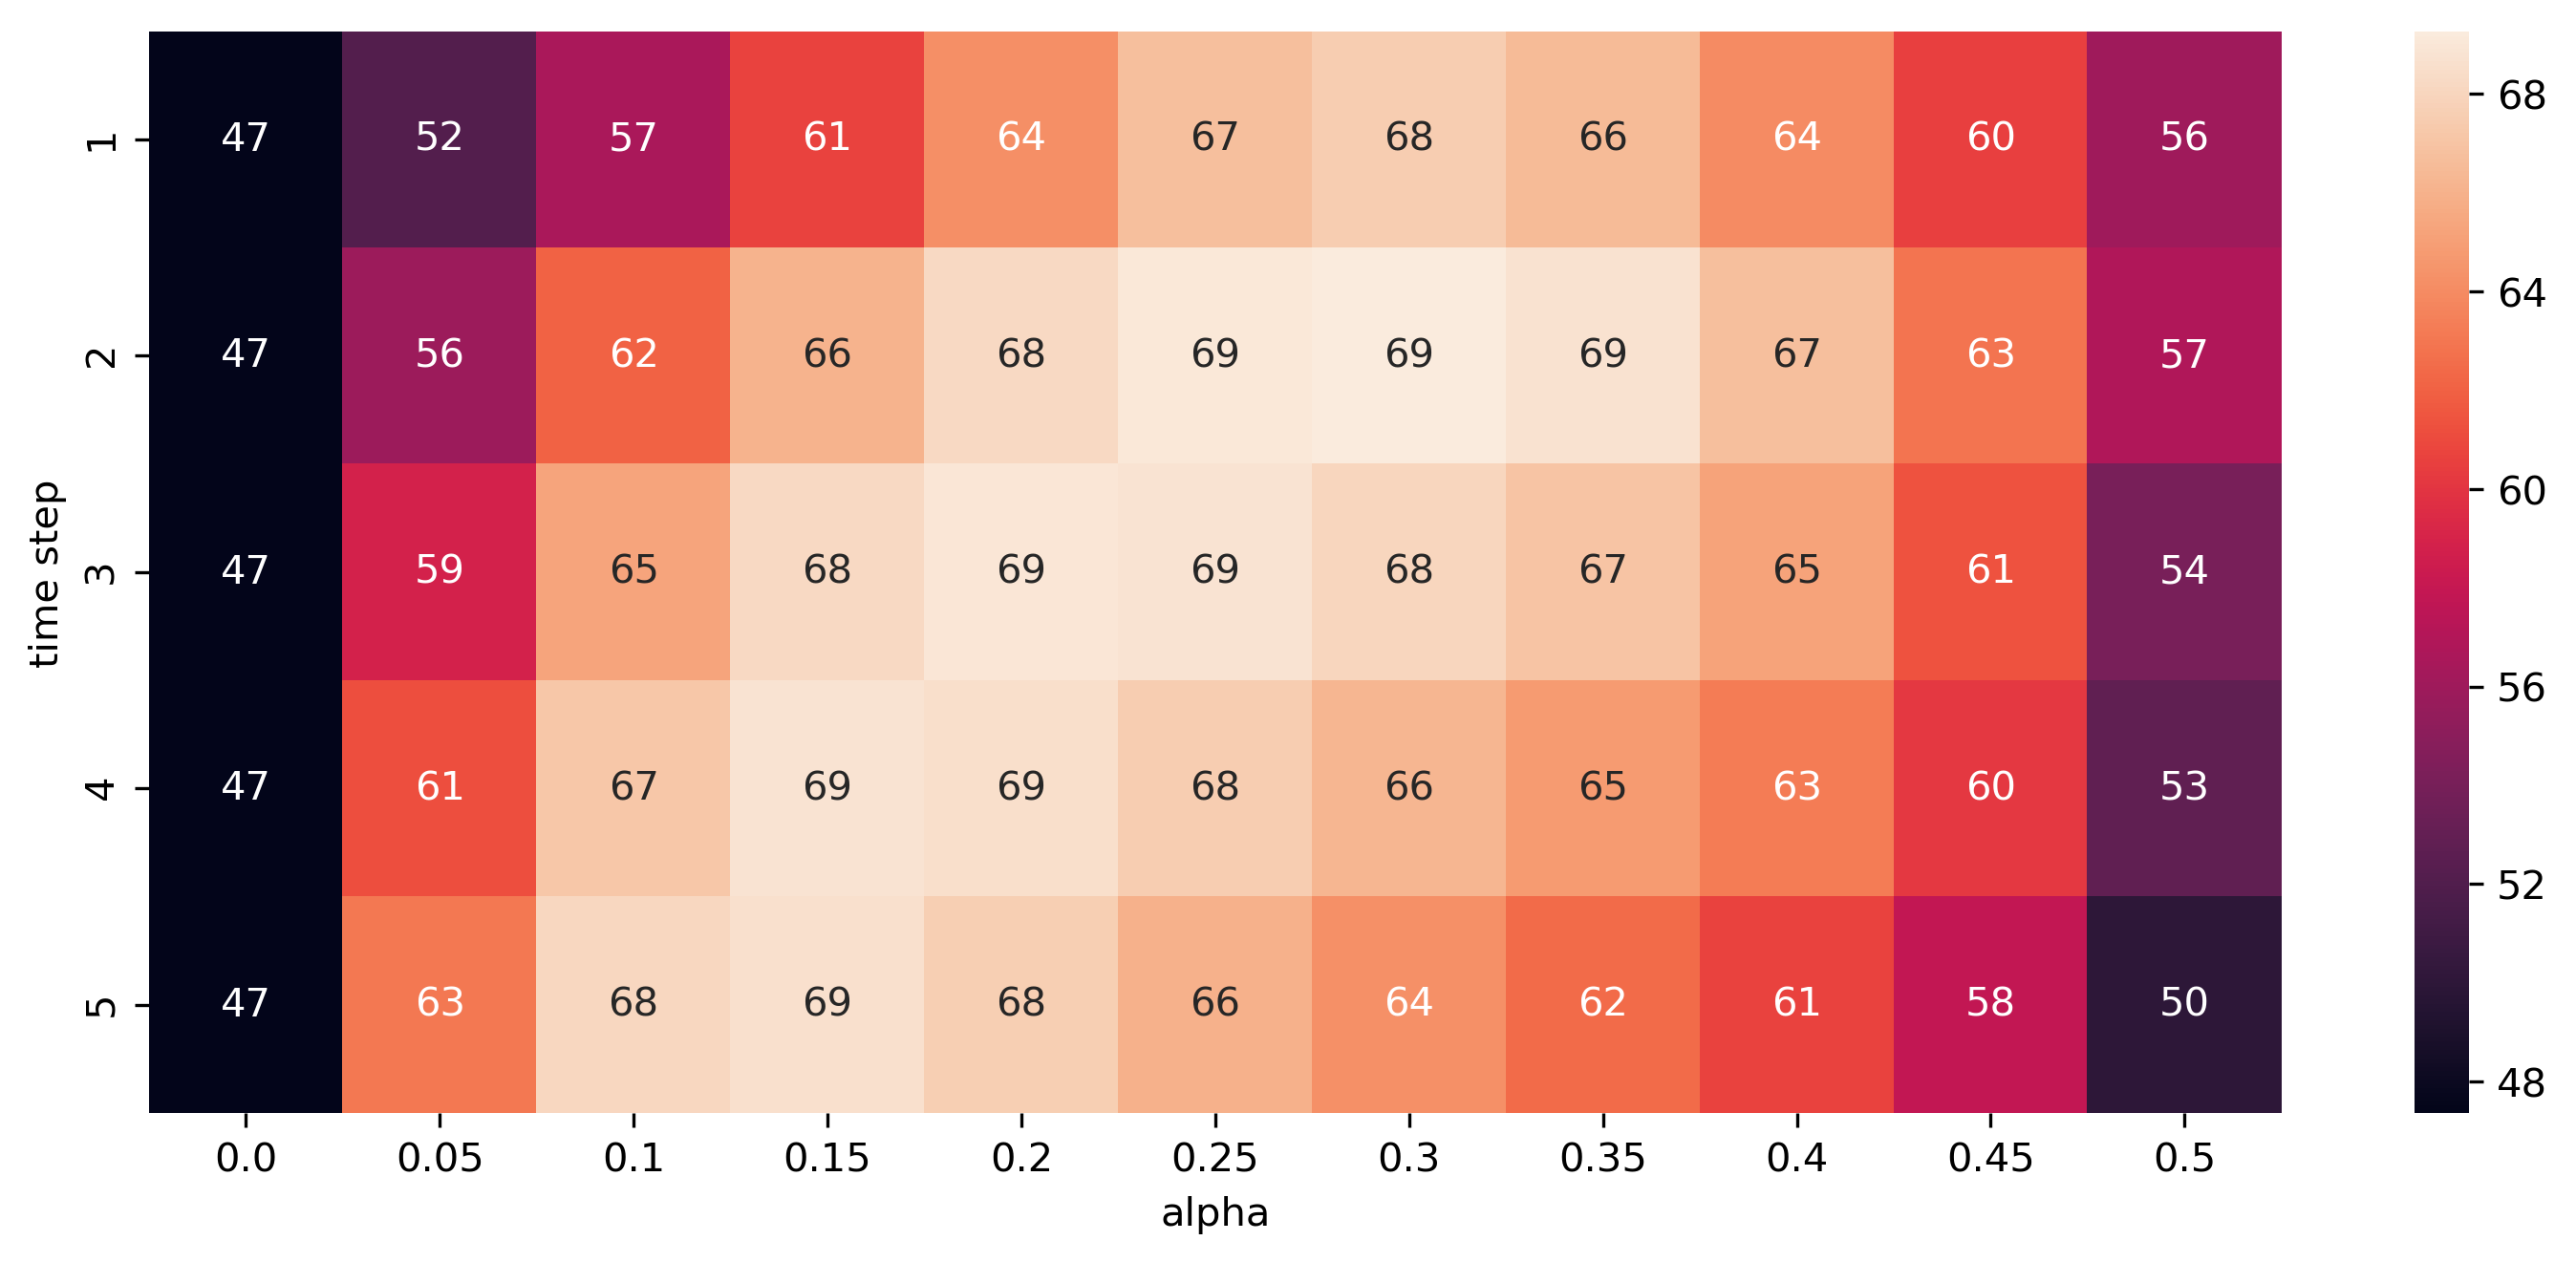

In [142]:
df_t = pd.DataFrame().from_dict(r)
fig, ax = plt.subplots(figsize=(12,5), dpi=300)

sns.heatmap(df_t, annot=True, ax=ax)
ax.set_ylabel('time step')
ax.set_xlabel('alpha')
fig.savefig(REGION + f'_{ERROR}.png')